## Structure Analysis and Chemical Shift Prediction 

Benjamin G. Janesko, Department of Chemistry & Biochemistry, Texas Christian University 
April 2025

This computational workflow performs conformational analysis with the RDKit, DFT refinement of low-energy conformations, and DFT prediction of 1H, 13C, 14N chemical shifts and spin-spin coupling constants.

If you're running in Google Colab, use the block below to install all necessary packages. 

In [ ]:
!pip install rdkit 
!pip install pyscf
!pip install py3Dmol
!pip install geometric
!pip install pyscf.properties
!pip install matplotlib

The next blocks import necessary Python packages and set up file format conversion 

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import py3Dmol
import numpy
import tabulate
from pyscf import gto,scf,dft
from pyscf.geomopt.geometric_solver import optimize
from pyscf.prop import nmr,ssc
import matplotlib.pyplot as plt
from rdkit.Geometry import Point3D

In [3]:
def RDKitToPySCF(rdkitmol,basis='3-21g'):
    elements = [atom.GetSymbol() for atom in rdkitmol.GetAtoms()]
    coordinates = rdkitmol.GetConformer().GetPositions()
    atoms = [(element, coordinate) for element, coordinate in zip(elements, coordinates)]

    pyscf_mole = gto.Mole(basis=basis)
    pyscf_mole.atom = atoms
    pyscf_mole.build();
    return(pyscf_mole)
    

In [4]:
def PySCFToRDKit(rdkitmol,pyscfmol):
    m2 = Chem.rdchem.Mol(rdkitmol)
    c  = m2.GetConformer()
    nc = pyscfmol.atom_coords() *0.529177
    for i in range(rdkitmol.GetNumAtoms()):
        c.SetAtomPosition(i,Point3D(nc[i,0],nc[i,1],nc[i,2]))
    return(m2)

## Part 1: Structure Input  

Use this line if you have a .mol file 

In [5]:
m0=Chem.MolFromMolFile('./thiadiazole.mol')

Use this line if you're copying a SMILES string from ChemDraw 

In [ ]:
m0=Chem.MolFromSmiles('OCCC1=NN=C(C=O)S1')

Check the molecule 2-D representation 

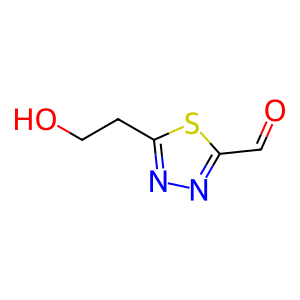

In [6]:
img = Draw.MolToImage(m0)
img

## Part 2: Conformational search 

Set nmol to your desired number of low-energy conformers 

In [7]:
nmol=3

This block runs the conformational search and selects the nmol lowest-energy conformers 

In [8]:
m1=Chem.AddHs(m0)
confids=AllChem.EmbedMultipleConfs(m1,numConfs=100)

# Find unique energies 
uniqueEs=[]
uniqueIDs=[]
for confid in confids:
    AllChem.MMFFOptimizeMolecule(m1,confId=confid)
    ff = AllChem.MMFFGetMoleculeForceField(m1, AllChem.MMFFGetMoleculeProperties(m1), confId=confid)
    E=ff.CalcEnergy()
    keep=1
    for Eold in uniqueEs:
        if((E-Eold)**2<0.000001):
            keep=0
    if(keep>0):
        uniqueEs.append(E)
        uniqueIDs.append(confid)
        
# Sort the unique energies energy 
sortedEs=[(x,y) for x,y in sorted(zip(uniqueEs,uniqueIDs))]
Emin=sortedEs[0][0]
print('Lowest energy: %.4f'%(Emin))



Lowest energy: 23.3292


This block prints the predicted 3-D structures of the low-energy conformers. Each conformer is labeled with its relative energy in kcal/mol  and the atom numbering.

For the thiadiazole example, the lowest-energy conformer includes an interal hydrogen bond between the R-OH group and one thiadiazole nitrogen. 

In [11]:
p=py3Dmol.view(width=800,height=400,viewergrid=(1,nmol))
for imol in range(nmol):
    ss=sortedEs[imol]
    confid=ss[1]
    E=ss[0]
    DE=(E-Emin)
    DElabel='%.2f'%(DE)
    p.addModel(Chem.MolToMolBlock(m1,confId=confid), 'sdf',viewer=(0,imol))
    p.addPropertyLabels("index",{},{'inFront':True,'fontColor':'black','fontSize':10,'fontOpacity':1,'backgroundColor':'white','backgroundOpacity':0})
    #p.addLabel(DElabel,{'inFront':True,'position':{'x':0.0,'y':-2,'z':0.0},'fontColor':'black','backgroundColor':'white'},viewer=(0,imol))
    p.setStyle({'stick':{},'sphere':{"scale":0.3}},viewer=(0,imol))
p.zoomTo()
p.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Part 3: DFT structure refinement

This block generates B3LYP/6-31G gas-phase optimized geometries. This is the slowest step in the workflow. 

In [ ]:
optmols=[]
for imol in range(nmol):
    ss=sortedEs[imol]
    confid=ss[1]
    mb3=Chem.Mol(m1,confId=confid)
    m3=RDKitToPySCF(mb3,basis='6-31g')
    m3.build()
    mf3=dft.RKS(m3,xc='b3lyp')
    #mf3=scf.RHF(m3)
    m4=optimize(mf3)
    optmols.append(m4)

In [ ]:
EminDFTs=[]
for imol in range(nmol):
    m4=optmols[imol]
    m4.basis='6-31+G(d)'
    m4.build()
    print(m4.nao)
    mf4=dft.RKS(m4,xc='b3lyp')
    mf4.kernel()
    EminDFTs.append(mf4.e_tot)

In [ ]:
# Draw pictures of the most stable optimized structures 
p=py3Dmol.view(width=800,height=300,viewergrid=(1,nmol))
for imol in range(nmol):
    ss=sortedEs[imol]
    confid=ss[1]
    m3=PySCFToRDKit(m1,optmols[imol])
    DE=627.5095*(EminDFTs[imol]-EminDFTs[0])
    DElabel='%.2f'%(DE)
    p.addModel(Chem.MolToMolBlock(m3), 'sdf',viewer=(0,imol))
    p.addPropertyLabels("index",{},{'inFront':True,'fontColor':'black','fontSize':12,'fontOpacity':1,'backgroundColor':'white','backgroundOpacity':0})
    p.addLabel(DElabel,{'inFront':True,'borderOpacity':0,'position':{'x':0.0,'y':-2,'z':0.0},'fontColor':'black','backgroundColor':'white','backgroundOpacity':0},viewer=(0,imol))
    #p.addLabel(DElabel,{'inFront':True,'fontColor':'black','backgroundColor':'white'},viewer=(0,imol))
    p.setStyle({'stick':{},'sphere':{"scale":0.3}},viewer=(0,imol))
p.zoomTo()
p.show()

## Part 4: Chemical shifts 

HF/6-31+G(d)//B3LYP/6-31G chemical shifts relative to that computed for a reference compound. Reference compounds are TMS for 1H and 13C, nitromethane for 15N. 

In [ ]:
refVals={'H':32.47,
        'C':199.47,
        'N':-272.23}

The next block does the calculations. 

In [ ]:
shields=[]
rhfs=[]
for imol in range(nmol):
    m4=optmols[imol]
    m4.basis='6-31+G(d)'
    m4.build()
    mf4=scf.RHF(m4)
    mf4.kernel()
    rhfs.append(mf4)
    mn5=nmr.rhf.NMR(mf4)
    sh5=mn5.kernel()
    shields.append(sh5)

The next block reports the chemical shifts for each of the low-energy conformers.

For this thiadiazole example, R-OH hydrogen atom 15 has chemical shift 4.6 in the lowest-energy hydrogen-bonded conformer, chemical shifts 1.5-1.7 in the other non-hydrogen-bonded conformers. 

In [ ]:
m=optmols[0]
for iat in range(m.natm):
    t=m.atom_symbol(iat)
    if(t in refVals):
        r=refVals[t]
        print('%2d %3s '%(iat,t),end='')
        for imol in range(nmol):
            s=shields[imol]
            val=(s[iat,0,0]+s[iat,1,1]+s[iat,2,2])/3
            print(' %9.2f'%(r-val),end='')
        print(' ')
    

## Part 5: Spin-Spin Coupling 

HF/6-31+G(d)//B3LYP/6-31G spin spin coupling constants 

Set cut to your desired cutoff for printed spin-spin couplings, in Hz 

In [ ]:
cut=4

This block does the spin-spin coupling calculations 

In [ ]:
sscs=[]
for imol in range(nmol):
    mf4=rhfs[imol]
    ms4=ssc.RHF(mf4)
    thessc=ms4.kernel()
    sscs.append(thessc)

This block prints the non-negligible SSCCs for 13C, 1H, and 15N nuclei, in Hz

In [ ]:
conv=487893880.
m=optmols[0]
for iat in range(m.natm):
    ti=m.atom_symbol(iat)
    if(ti in refVals):
        for jat in range(iat+1,m.natm):
            ijat=int(jat*(jat-1)/2+iat)
            tj=m.atom_symbol(jat)
            if(tj in refVals):
                ss0=sscs[0]
                vv = conv*(ss0[ijat,0,0]+ss0[ijat,1,1]+ss0[ijat,2,2])/3
                if(vv**2>cut**2):
                    print('%2d %2d %3s %3s'%(iat,jat,ti,tj),end='')
                    for imol in range(nmol):
                        s=sscs[imol][ijat]
                        val=conv*(s[0,0]+s[1,1]+s[2,2])/3
                        print(' %9.2f'%(val),end='')
                    print(' ')
    